In [10]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [11]:
folder_nonlinear = './results_nonlinear'

csv_file_nonlinear = 'nonlinear_results_summary.csv'

figures_folder = './figures'
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)


In [ ]:
# Define a function to process a single file
def process_file(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    # Extract columns, using placeholders for missing data
    scenario_name = data.get("model_file", "-").replace('.json', '')
    algorithm = data.get("configuration", {}).get("algorithm", "-")
    size = data.get("configuration", {}).get("size", "-")
    optimizer = data.get("configuration", {}).get("optimizer", "-")
    annealings = data.get("configuration", {}).get("nonlinear_annealings", "-")
    iterations = data.get("configuration", {}).get("nonlinear_iterations", "-")

    reasoner = data.get("reasoner_results", {})
    if isinstance(reasoner, str):
        print(f"File {filepath} has reasoner results as a string, converting to dict.")
        reasoner = {"status": reasoner}
    status = reasoner.get("status", "-")
    score = reasoner.get("score", "-")
    evaluation = reasoner.get("evaluation", "-")
    exec_time = reasoner.get("solver_exec_time", "-")
    total_cost = reasoner.get("total_cost", "-")
    max_time = reasoner.get("max_time", "-")
    min_fidelity = reasoner.get("min_fidelity", "-")
    dispatch = reasoner.get("dispatch", {})

    if scenario_name == "scenario2":
        evaluation = -evaluation

    if  optimizer == "nonlinear":
        baseline = "qb-nonlinear"
    else:
        raise ValueError("This function is for nonlinear optimizer results only.")
    # Row for DataFrame
    row = {
        #"baseline": baseline,
        "scenario_name": scenario_name,
        "algorithm": algorithm,
        "size": size,
        #"optimizer": optimizer,
        "annealings": annealings,
        "iterations": iterations,
        "status": status,
        #"score": score,
        "evaluation": evaluation,
        "exec_time": exec_time,
        #"total_cost": total_cost,
        #"max_time": max_time,
        #"min_fidelity": min_fidelity
    }
    
    # Key for dispatches dict
    dispatch_key = (scenario_name, algorithm, size, optimizer, annealings, iterations)
    
    return row, dispatch_key, dispatch

In [13]:
data_rows = []
dispatches = {}

if os.path.exists(csv_file_nonlinear):
    df = pd.read_csv(csv_file_nonlinear)    
else:
    base_files = [os.path.join(folder_nonlinear, f) for f in os.listdir(folder_nonlinear) if f.endswith('.json')]
    for file in base_files:
        row, key, dispatch = process_file(file)
        data_rows.append(row)
        dispatches[key] = dispatch

    # Create DataFrame
    df = pd.DataFrame(data_rows)
    df.to_csv(csv_file_nonlinear, index=False)

# Show results
print("DataFrame:")
df['algorithm'] = df['algorithm'].replace('realamprandom', 'realamprnd')
df['algorithm'] = df['algorithm'].replace('twolocalrandom', 'twolocalrnd')
display(df)

#print("\nDispatches dictionary (keys and values):")
#for k, v in dispatches.items():
#    print(f"{k}: {v}")



DataFrame:


,scenario_name,algorithm,size,annealings,iterations,status,evaluation,exec_time
0,scenario2,qaoa,6,20,30,solution_found,-670.764271,34.758863
1,scenario2,qnn,6,1,50,solution_found,-364.791373,3.126637
2,scenario1,qaoa,8,25,45,solution_found,575.187712,29.919923
3,scenario2,qaoa,10,30,1,solution_found,-630.774659,3.185143
4,scenario1,twolocalrnd,10,1,5,solution_found,210.940863,1.143561
...,...,...,...,...,...,...,...,...
2107,scenario2,qaoa,6,5,30,solution_found,-668.981819,8.982114
2108,scenario1,dj,8,25,25,solution_found,470.662544,28.332482
2109,scenario2,realamprnd,6,10,25,solution_found,-253.021304,13.934010
2110,scenario3,qaoa,10,30,15,solution_found,435.400000,21.930080


In [14]:
df.columns



Index(['scenario_name', 'algorithm', 'size', 'annealings', 'iterations',
       'status', 'evaluation', 'exec_time'],
      dtype='object')

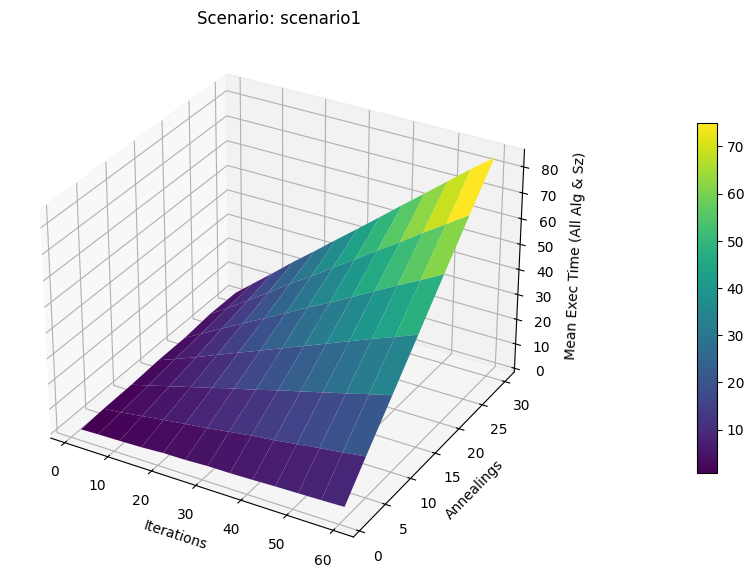

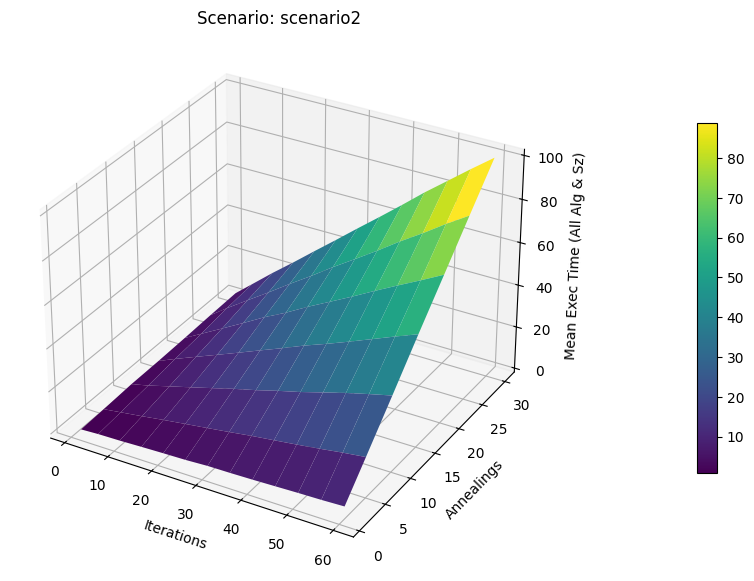

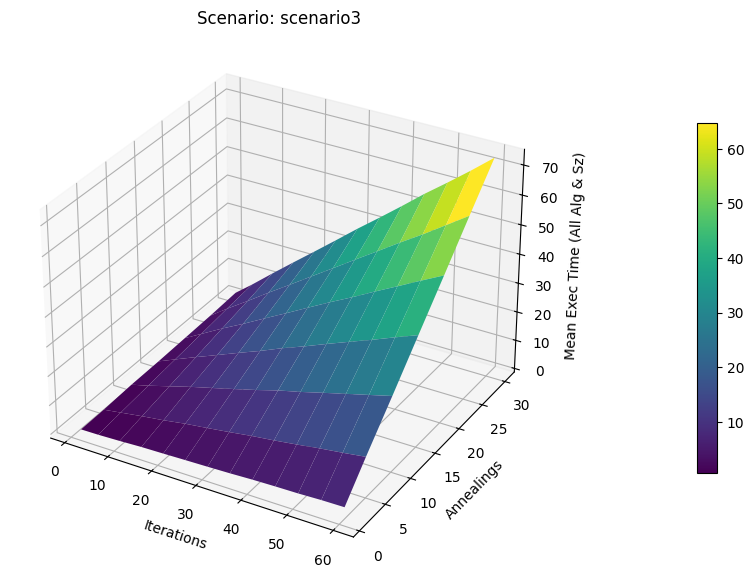

In [15]:
# Group by scenario_name, iterations, annealings and compute mean exec_time
df_grouped = df.groupby(
    ['scenario_name', 'iterations', 'annealings']
)['exec_time'].mean().reset_index()

for scenario in df_grouped['scenario_name'].unique():
    sub_df = df_grouped[df_grouped['scenario_name'] == scenario]
    pivot = sub_df.pivot_table(
        index='iterations', columns='annealings', values='exec_time'
    )
    X, Y = np.meshgrid(pivot.index, pivot.columns)
    Z = pivot.values.T

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')

    ax.set_title(f'Scenario: {scenario}')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Annealings')
    ax.set_zlabel('Mean Exec Time (All Alg & Sz)')

    # Create a new axis for the colorbar to the right of the plot
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
    fig.colorbar(surf, cax=cax)
    
    plt.subplots_adjust(right=0.88)  # Make room for colorbar
    plt.show()


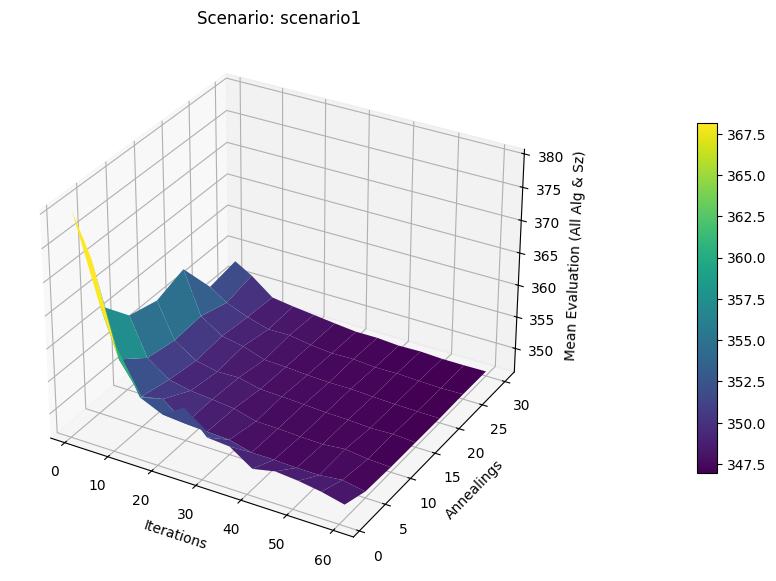

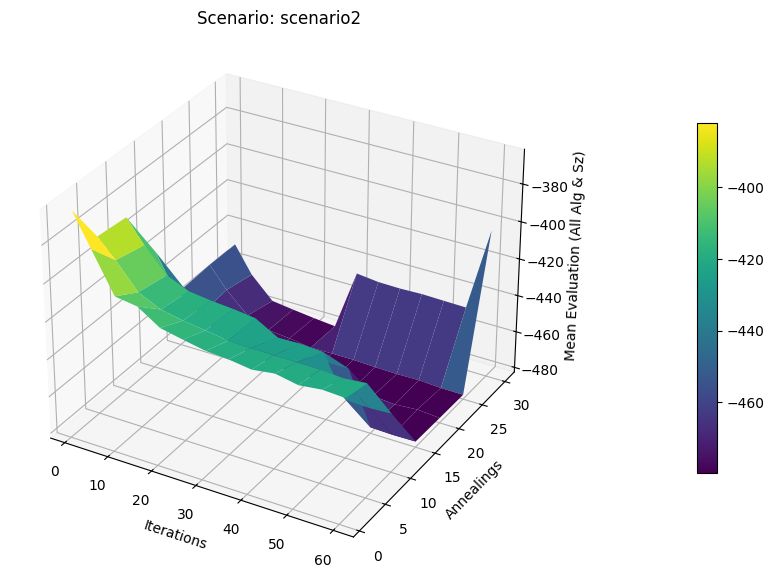

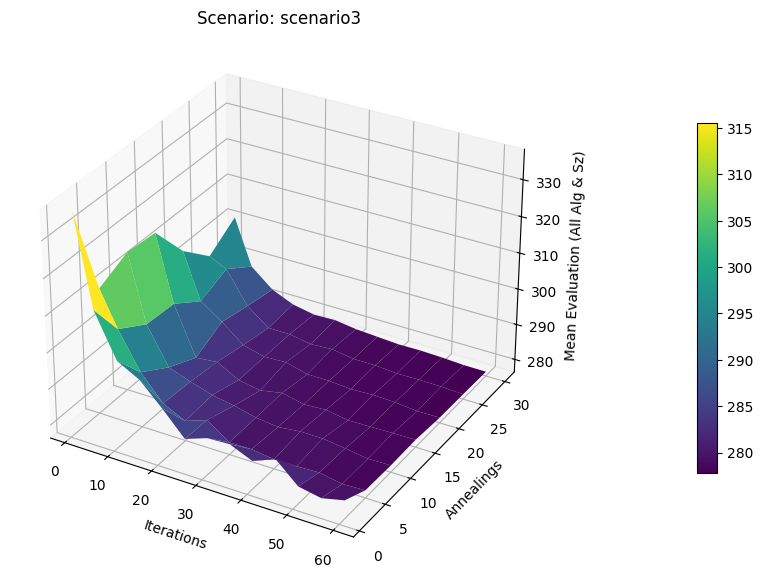

In [16]:
# Group by scenario_name, iterations, annealings and compute mean evaluation
df_grouped2 = df.groupby(
    ['scenario_name', 'iterations', 'annealings']
)['evaluation'].mean().reset_index()

for scenario in df_grouped2['scenario_name'].unique():
    sub_df = df_grouped2[df_grouped2['scenario_name'] == scenario]
    pivot = sub_df.pivot_table(
        index='iterations', columns='annealings', values='evaluation'
    )
    X, Y = np.meshgrid(pivot.index, pivot.columns)
    Z = pivot.values.T

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')

    ax.set_title(f'Scenario: {scenario}')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Annealings')
    ax.set_zlabel('Mean Evaluation (All Alg & Sz)')

    # Create a new axis for the colorbar to the right of the plot
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
    fig.colorbar(surf, cax=cax)
    
    plt.subplots_adjust(right=0.88)  # Make room for colorbar
    plt.show()
